У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [36]:
import pandas as pd

df = pd.read_csv('time_series_train.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
**Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



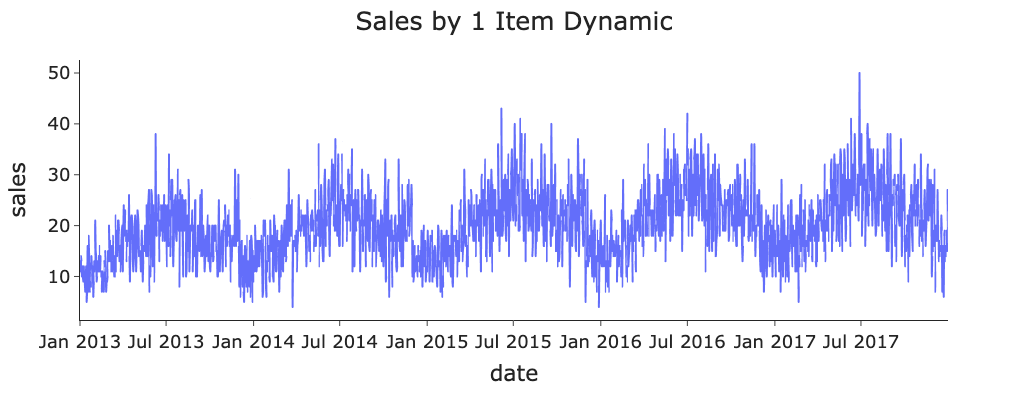

In [37]:
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np

fig = px.line(df[(df['store'] == 1) & (df['item'] == 1)], y='sales')

fig.update_layout(template="simple_white", font=dict(size=18),
                  title_text='Sales by 1 Item Dynamic', width=950, title_x=0.5, height=400)

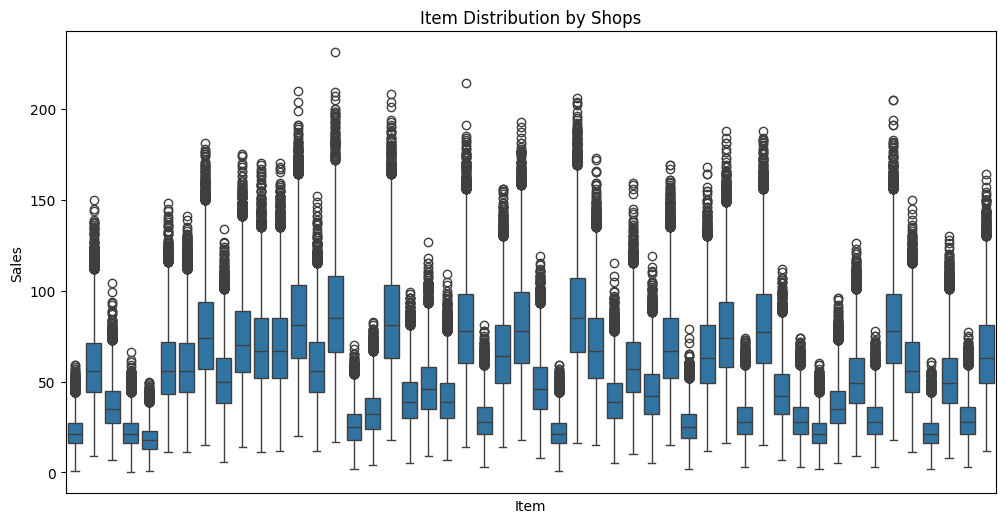

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="item", y="sales")
plt.xticks([])  # Приховати мітки для кращої читабельності
plt.title("Item Distribution by Shops")
plt.xlabel("Item")
plt.ylabel("Sales")
plt.show()

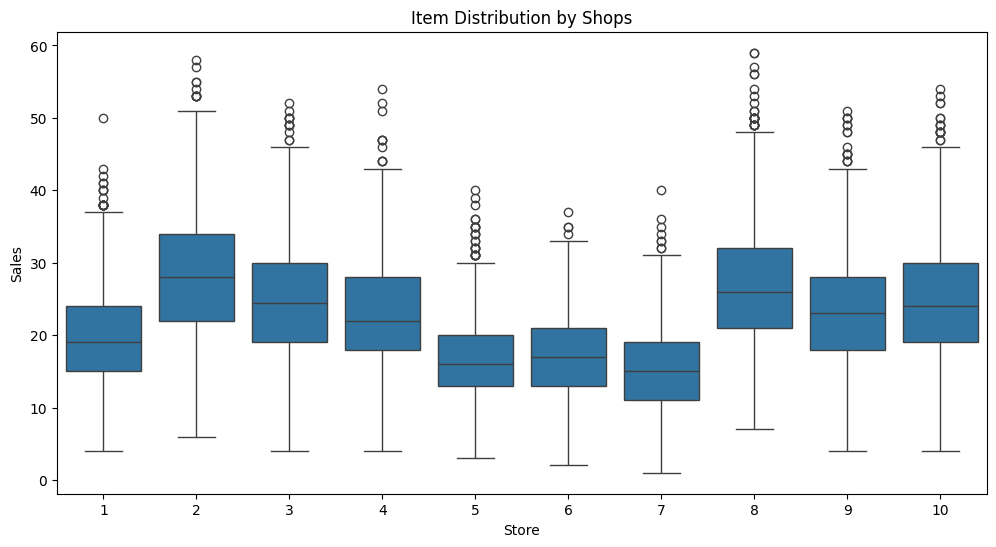

In [39]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[(df['item'] == 1)], x="store", y="sales")
plt.xticks()  # Приховати мітки для кращої читабельності
plt.title("Item Distribution by Shops")
plt.xlabel("Store") 
plt.ylabel("Sales")
plt.show()

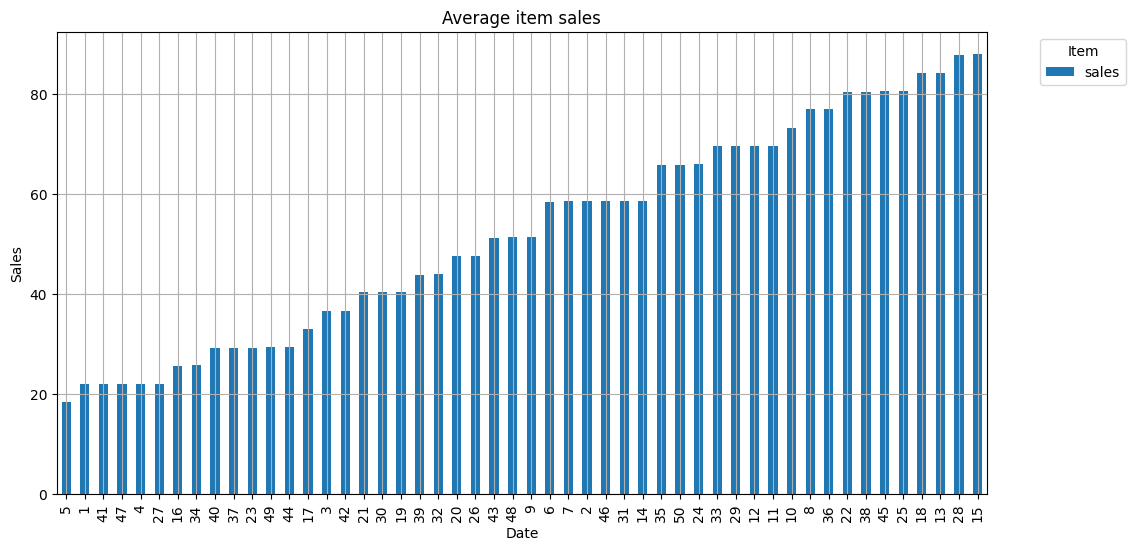

In [40]:
# Групування даних
df_grouped = df.groupby(['item'])['sales'].mean().sort_values()

# Побудова графіка
plt.figure(figsize=(12, 6))
df_grouped.plot(kind='bar')
plt.title("Average item sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(title="Item", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()

Висновки за набором даних:
* В наборі присутня річна сезонність, бачимо що найбільші продажі айтемів присутні саме в липні-серпні. Тобто скоріше за все це товари, що користуються більшим попитом саме влітку, взимку попит спадає.
* Box plot діаграма показує, що присутні товари, які є дешевшими в ціні, але викиди кажуть про те, що ймовірно, є локації з більшими цінами на усі товари. Це і перевіримо.
* Розподіл вартості товару за магазинами показує, що в магазинах 2,8,9,10 апріорі вищі ціни на усі продукти, не зважаючи на тип. Можливо магазин розташований в кращій локації, або користується більшим попитом.
* Останній графік показує середню вартість товарів: найдешевший товар - 5, найдорожчі 28 та 15

3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

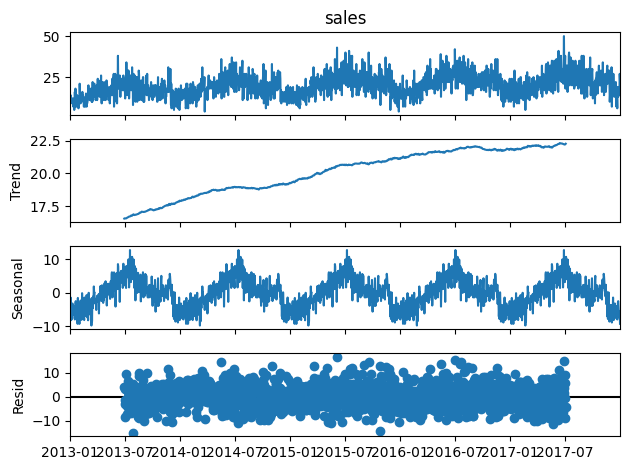

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

decomposition_plot_multi = seasonal_decompose(df[(df['store'] == 1) & (df['item'] == 1)]['sales'],
                                              model='additive', period=360)
decomposition_plot_multi.plot()
plt.show()

Statsmodels показав явний тренд, який є лінійним, та постійно зростаючим. Річна сезонність присутня, показники сезонності коливаються від -10 до 10. Залишки гомоскедастичні, не бачу явної залежності між залишками.

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [23]:
!pip install darts

Defaulting to user installation because normal site-packages is not writeable


In [54]:
from darts import TimeSeries

sub_df = df[(df['store'] == 1) & (df['item'] == 1)]
series = TimeSeries.from_dataframe(sub_df, value_cols='sales')

In [55]:
series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) <U5 20B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

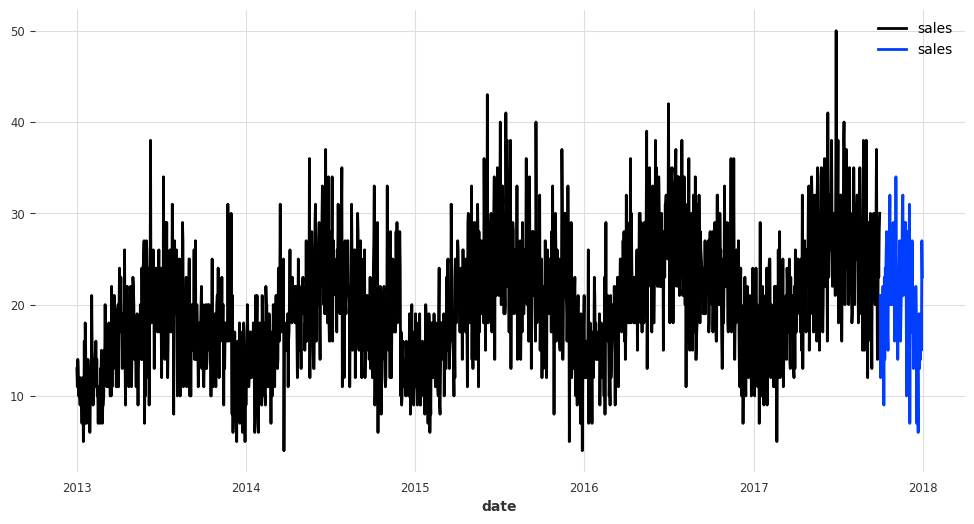

In [57]:
plt.figure(figsize=(12, 6))

train_series, val_series = series.split_before(pd.to_datetime('2017-10-01'))
train_series.plot()
val_series.plot()

plt.show()

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF)')

<Figure size 1000x600 with 0 Axes>

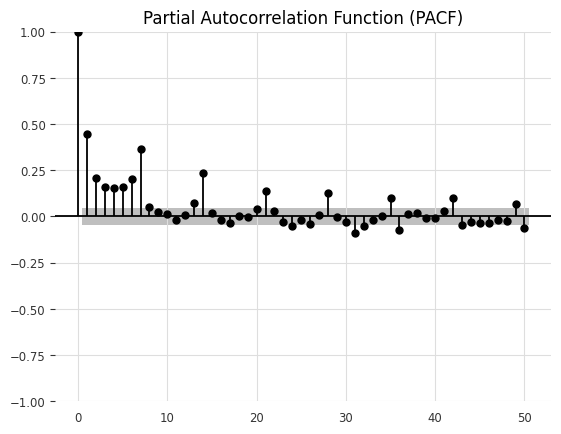

In [68]:
from statsmodels.graphics.tsaplots import plot_pacf

# у мене чомусь не працювало з series з бібліотеки Darts
plt.figure(figsize=(10, 6))
plot_pacf(sub_df['sales'], lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

Згідно часткової автокореляції, найбільш важливими для аналізу є 1-7 лаги, 13-14, 21, 28, 29 лаги. Тобто бачимо що орієнтовно кожен 7 лаг є важливим

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

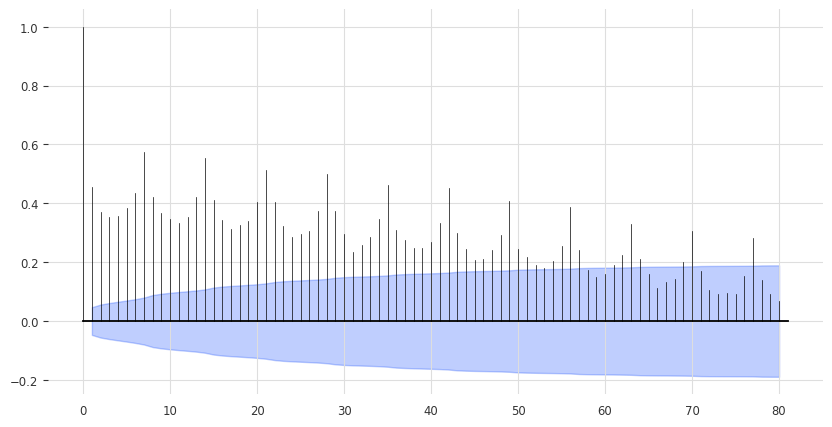

In [69]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train_series, max_lag=80)

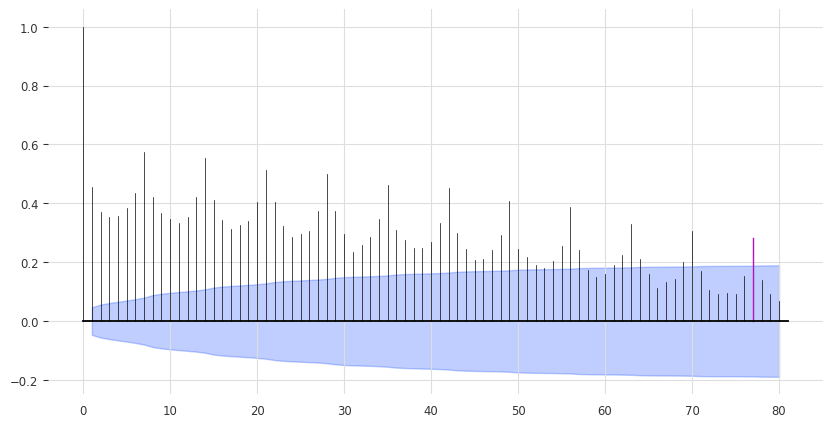

In [70]:
plot_acf(train_series, max_lag=80, m=77)

Очевидно, що присутня сезонність складає 7, оскільки пікові значення повторюються і є значно вищими за рівень значущості 0.05%. ACF показує пік на 7, 14, 21, 28, 35, 42.

In [84]:
seasonal_periods = []

for m in range(2, 200, 1):
    is_seasonal, period = check_seasonality(train_series, max_lag=200, m=m, alpha=0.05)
    if is_seasonal:
        seasonal_periods.append(period)
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.
There is seasonality of order 28.
There is seasonality of order 35.
There is seasonality of order 42.
There is seasonality of order 49.
There is seasonality of order 56.
There is seasonality of order 63.
There is seasonality of order 70.
There is seasonality of order 74.
There is seasonality of order 77.
There is seasonality of order 84.
There is seasonality of order 91.
There is seasonality of order 98.
There is seasonality of order 105.
There is seasonality of order 112.
There is seasonality of order 119.
There is seasonality of order 126.
There is seasonality of order 133.


8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

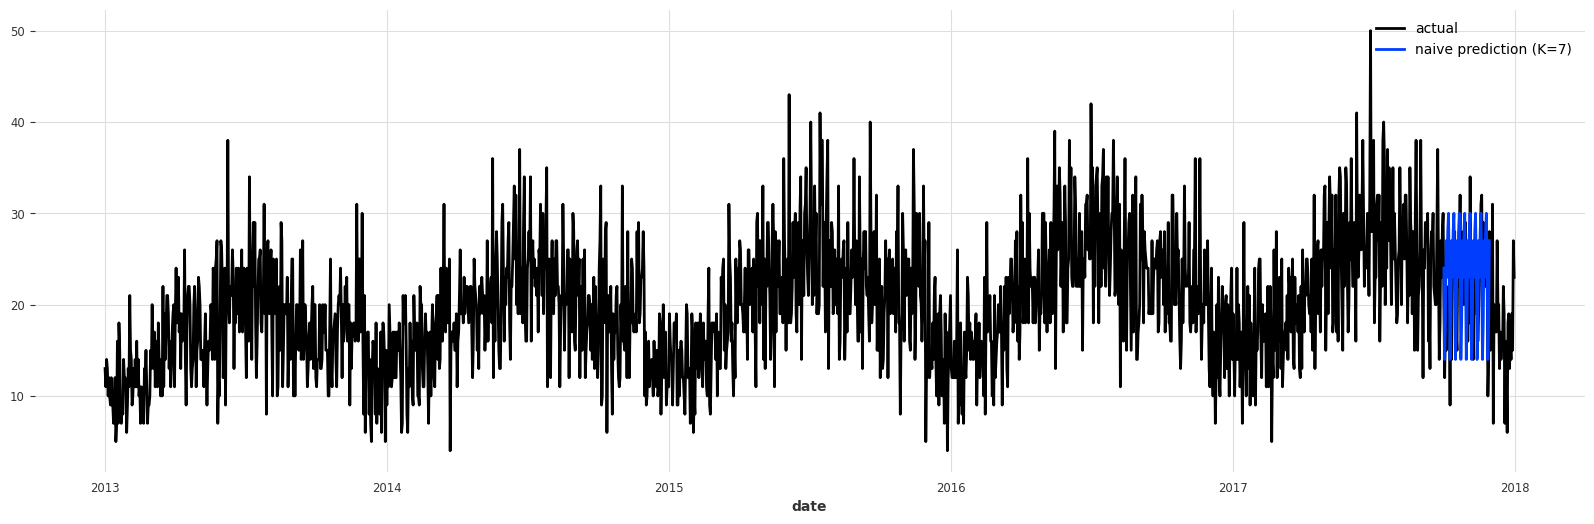

In [353]:
from darts.models import NaiveSeasonal

k = 7
seasonal_model = NaiveSeasonal(K=k)
seasonal_model.fit(train_series)
seasonal_forecast = seasonal_model.predict(60)

fig = plt.figure(figsize=(20, 6))

series.plot(label="actual")
seasonal_forecast.plot(label=f"naive prediction (K={k})")
plt.show()

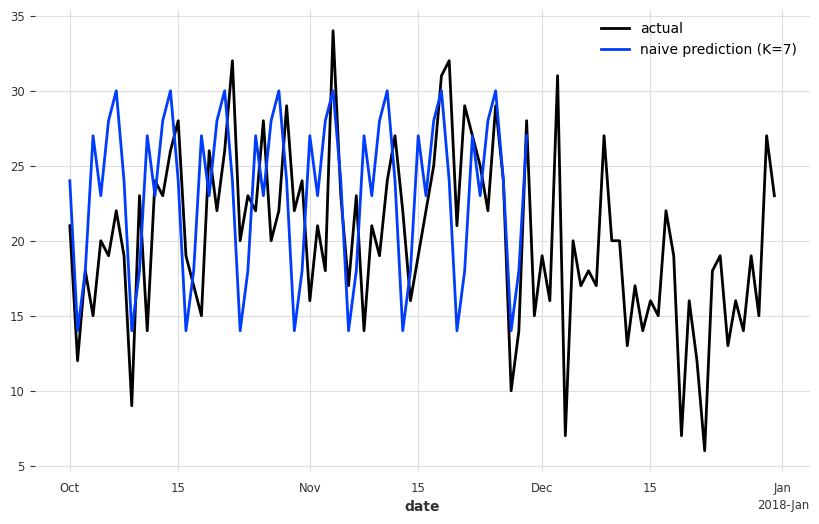

In [354]:
fig = plt.figure(figsize=(10, 6))
val_series.plot(label="actual")
seasonal_forecast.plot(label=f"naive prediction (K={k})")
plt.show()

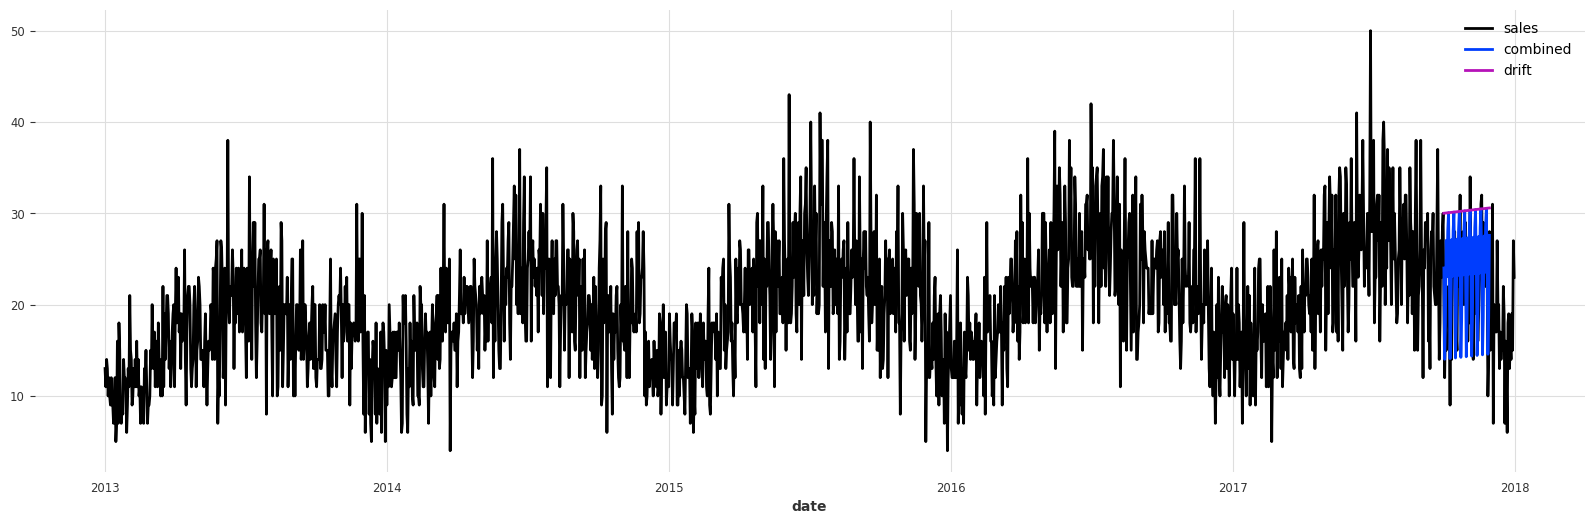

In [355]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train_series)
drift_forecast = drift_model.predict(60)

combined_forecast = drift_forecast + seasonal_forecast - train_series.last_value()

fig = plt.figure(figsize=(20, 6))

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")
plt.show()

<Axes: xlabel='date'>

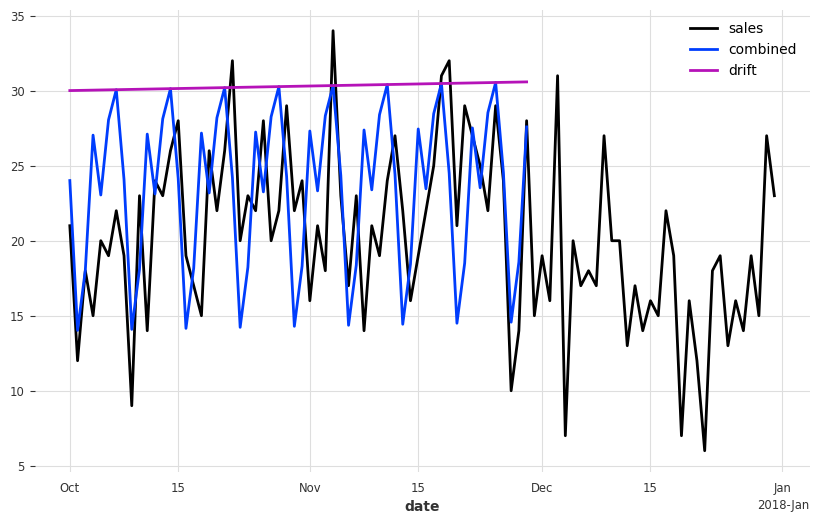

In [356]:
fig = plt.figure(figsize=(10, 6))

val_series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [357]:
from darts.metrics import mape

print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(series, combined_forecast):.2f}%."
)

Mean absolute percentage error for the combined naive drift + seasonal: 26.98%.


Модель дуже посередній предикт. Спробуємо й інші моделі

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [127]:
from darts.models import ExponentialSmoothing, AutoARIMA, Theta

def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

def fit_eval_model(model):
    model.fit(train_series)
    forecast = model.predict(len(val_series))
    eval_forecast(model, val_series, forecast)

In [133]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

def enrich_with_date_features(df):
  df["quarter"] = df['date'].dt.quarter
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  return df

# Додавання ознак дати
train_transformed = enrich_with_date_features(train_series.to_dataframe().reset_index())
val_transformed = enrich_with_date_features(val_series.to_dataframe().reset_index())

# Масштабування даних
scaler = Scaler()
train_transformed = scaler.fit_transform(train_series)
test_transformed = scaler.transform(val_series)

# Побудова моделі XGBoost
model = XGBModel(
    lags=35,  # Використання останніх 12 спостережень для прогнозування
    output_chunk_length=1,  # Прогнозування на 1 крок вперед
    n_estimators=200,  # Кількість дерев у моделі
    max_depth=3,  # Максимальна глибина кожного дерева
    learning_rate=0.1,  # Коефіцієнт навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8  # Частка ознак, що використовуються для кожного дерева
)

# Тренування моделі
model.fit(train_transformed)
pred = model.predict(6)
scaler.inverse_transform(pred)

<TimeSeries (DataArray) (date: 6, component: 1, sample: 1)> Size: 24B
array([[[27.652235]],

       [[18.927164]],

       [[21.488264]],

       [[21.660875]],

       [[23.828135]],

       [[27.642653]]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 48B 2017-10-01 2017-10-02 ... 2017-10-06
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

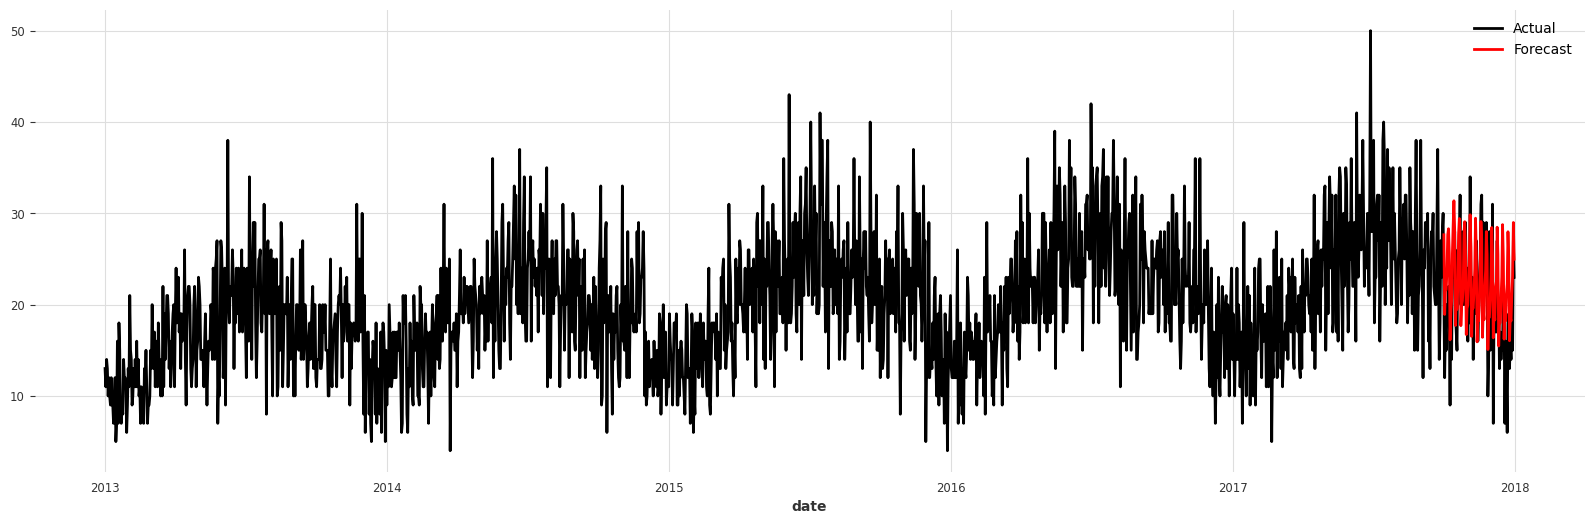

model XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) obtains MAPE: 29.85%


In [134]:
forecast = scaler.inverse_transform(model.predict(len(val_series)))

fig = plt.figure(figsize=(20, 6))

series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()
eval_forecast(model, val_series, forecast);

Модель XGB показала кращий результат, МАРЕ на 3% нижче за наївну модель

11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

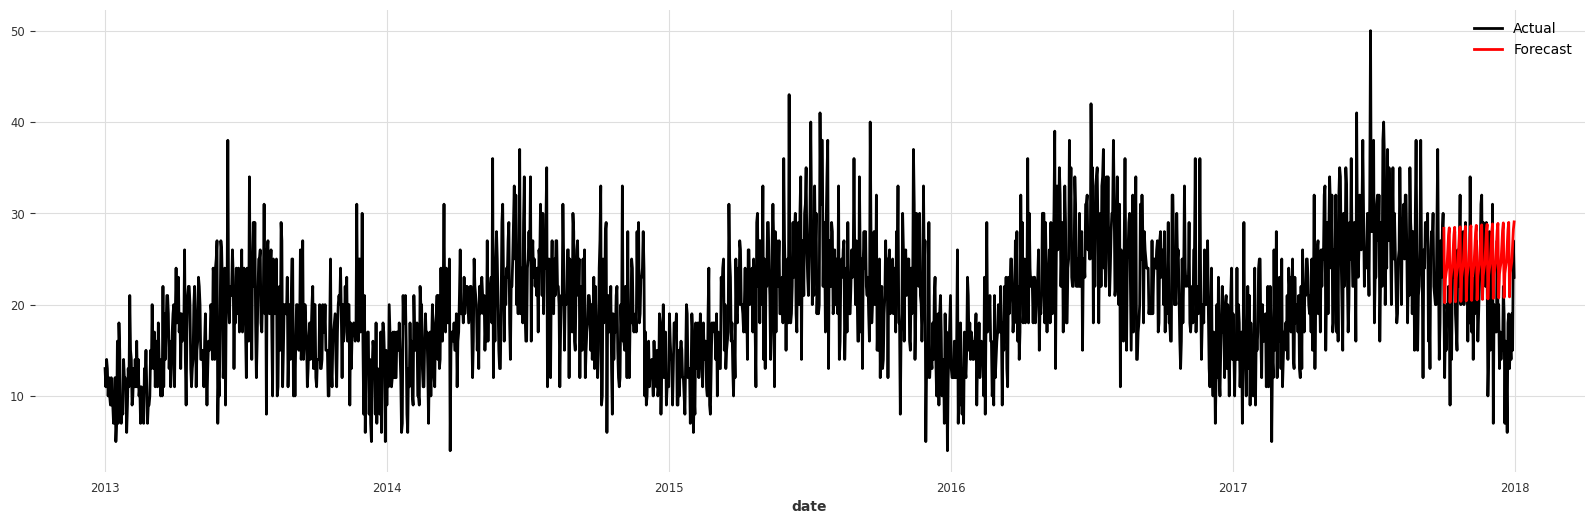

model ExponentialSmoothing() obtains MAPE: 39.01%


In [135]:
def plot_results(series, forecast):
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);

fig = plt.figure(figsize=(20, 6))

model = ExponentialSmoothing()
fit_and_plot(model, series, train_series, val_series)

На даний момент Exponential Smoothing дала найнижчий показник MAPE

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

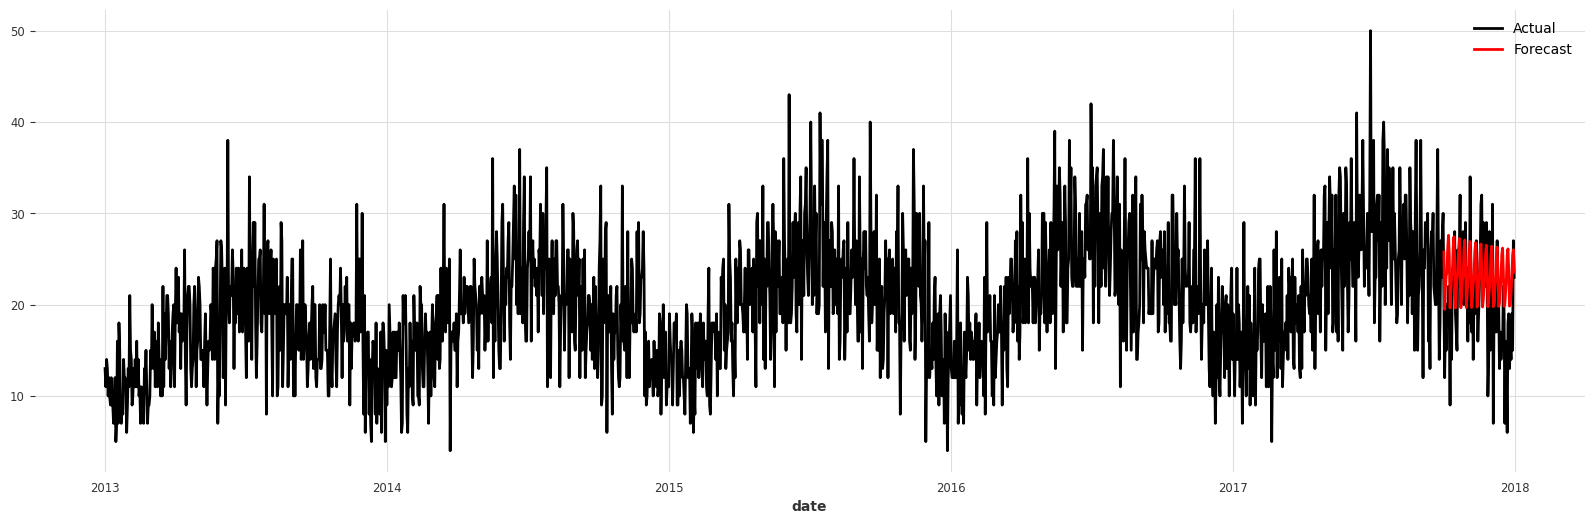

model ARIMA(p=9, q=10) obtains MAPE: 33.59%


In [145]:
from darts.models import ARIMA

fig = plt.figure(figsize=(20, 6))

model = ARIMA(p=9, d=1, q=10)
fit_and_plot(model, series, train_series, val_series)

ARIMA з поточними показниками показала кращий результат, ніж Exponential Smoothing, проте гірший за наївну модель та XGB.

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

AutoARIMA(add_encoders=None, start_p=7, max_p=12, start_q=8, max_q=14)

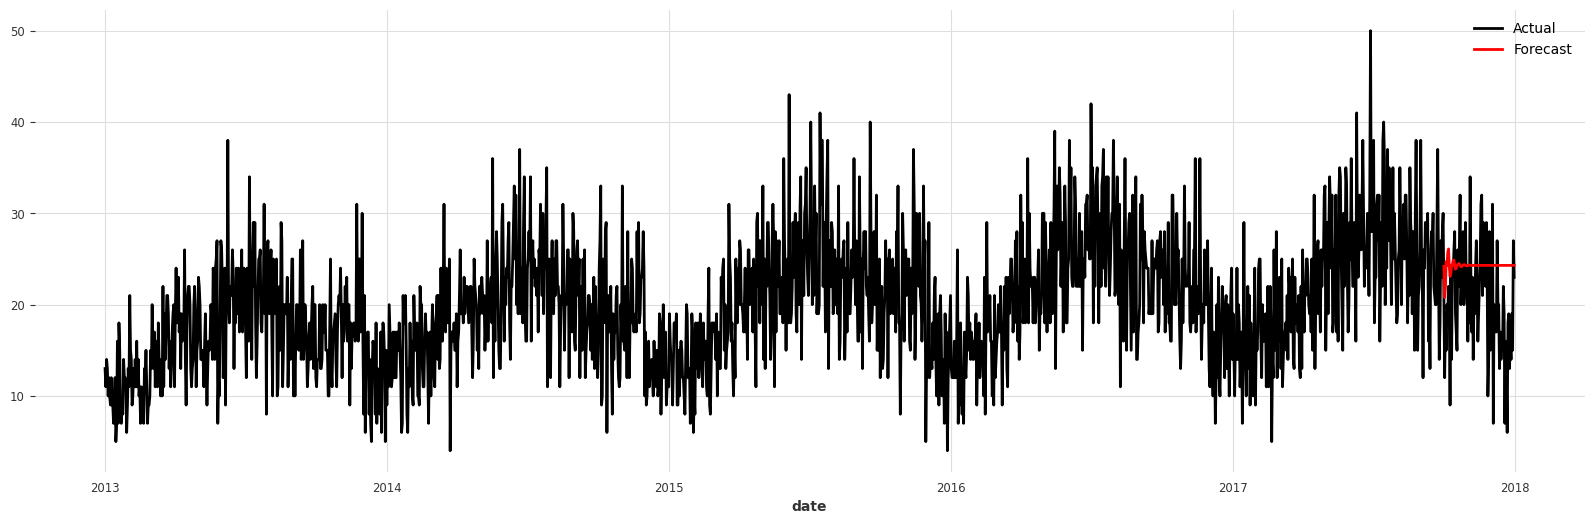

model AutoARIMA(start_p=7, max_p=12, start_q=8, max_q=14) obtains MAPE: 39.53%


In [148]:
model = AutoARIMA(start_p=7, max_p=12, start_q=8, max_q=14) 

display(model)
fig = plt.figure(figsize=(20, 6))

fit_and_plot(model, series, train_series, val_series)

AutoARIMA показала найнижчі показники МАРЕ

14. Натренуйте модель Prophet та зробіть висновок про її якість.

In [160]:
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable


15:02:25 - cmdstanpy - INFO - Chain [1] start processing
15:02:26 - cmdstanpy - INFO - Chain [1] done processing


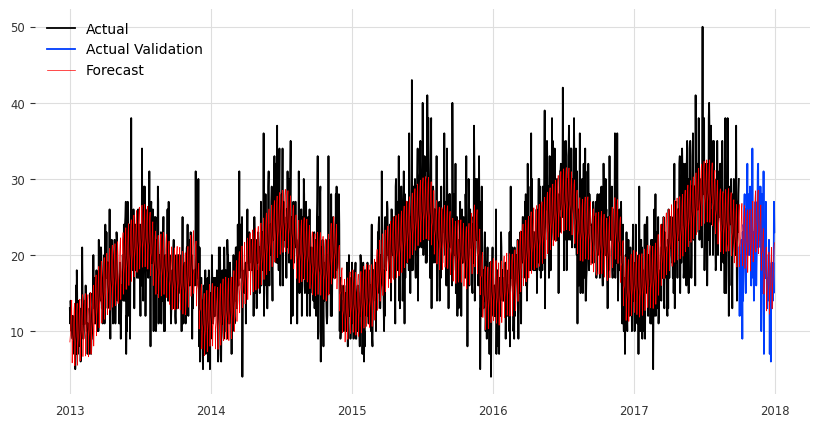

model <prophet.forecaster.Prophet object at 0x2c9700380> obtains MAPE: 43.63%


43.634868863821296

In [244]:
from prophet import Prophet

df_train_series = pd.DataFrame({"ds": train_series.to_dataframe().index.values,
                                "y": train_series.to_dataframe()['sales'].values})

df_val_series = pd.DataFrame({"ds": val_series.to_dataframe().index.values,
                                "y": val_series.to_dataframe()['sales'].values})

# Побудова та тренування моделі Prophet
model = Prophet()
model.fit(df_train_series)

future = model.make_future_dataframe(periods=len(df_val_series))
forecast = model.predict(future)

# Візуалізація результатів
plt.figure(figsize=(10, 5))
plt.plot(df_train_series['ds'], df_train_series['y'], label='Actual')
plt.plot(df_val_series['ds'], df_val_series['y'], label='Actual Validation')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red', linewidth=0.5)
plt.legend()
plt.show()

eval_forecast(model, TimeSeries.from_values(df_val_series['y'].values), TimeSeries.from_values(forecast['yhat'].values))

Prophet повернула показник MAPE: **43.63%**, але модель непогано передбачила тренд

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

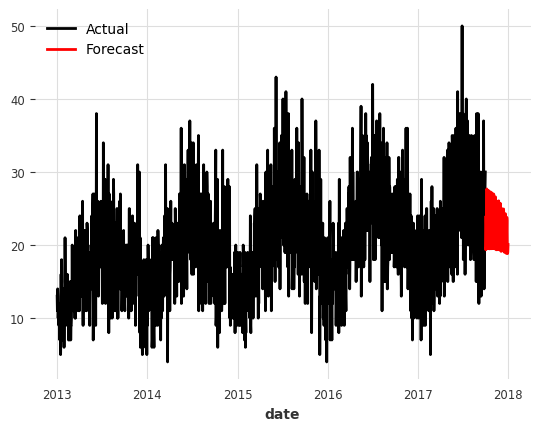

In [251]:
from darts.models import RNNModel
import torch

train_series = train_series.astype('float32')
val_series = val_series.astype('float32')

# Побудова та тренування моделі LSTM
model = RNNModel(model='LSTM', input_chunk_length=12, n_epochs=300)
model.fit(train_series)

# Прогнозування
forecast = model.predict(len(val_series))

# Переведення прогнозу в float32, якщо потрібно
forecast = forecast.astype('float32')

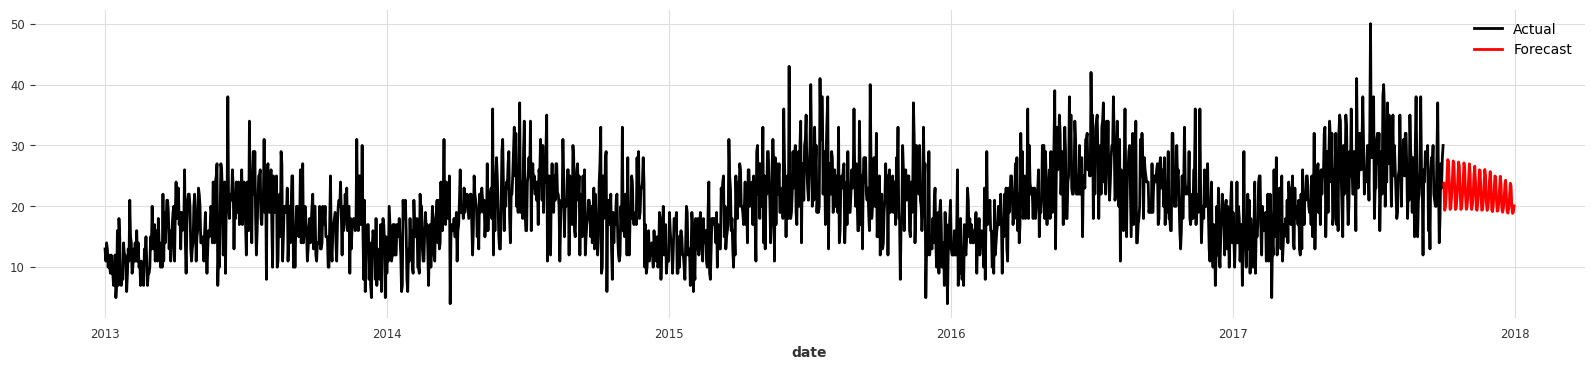

In [253]:
fig = plt.figure(figsize=(20, 4))
train_series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()

In [262]:
eval_forecast(model, val_series, forecast)

model RNNModel(model=LSTM, input_chunk_length=12, n_epochs=300) obtains MAPE: 33.62%


33.61521

LSTM показала показник 33.62%. Це краще ніж Prophet за показниками, але Prophet краще передбачив тренд.

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [393]:
# Найкраща модель 

k = 7
model = NaiveSeasonal(K=k)
model.fit(train_series)
seasonal_forecast = model.predict(60)

historical forecasts:   0%|          | 0/365 [00:00<?, ?it/s]

MAPE = 26.14%


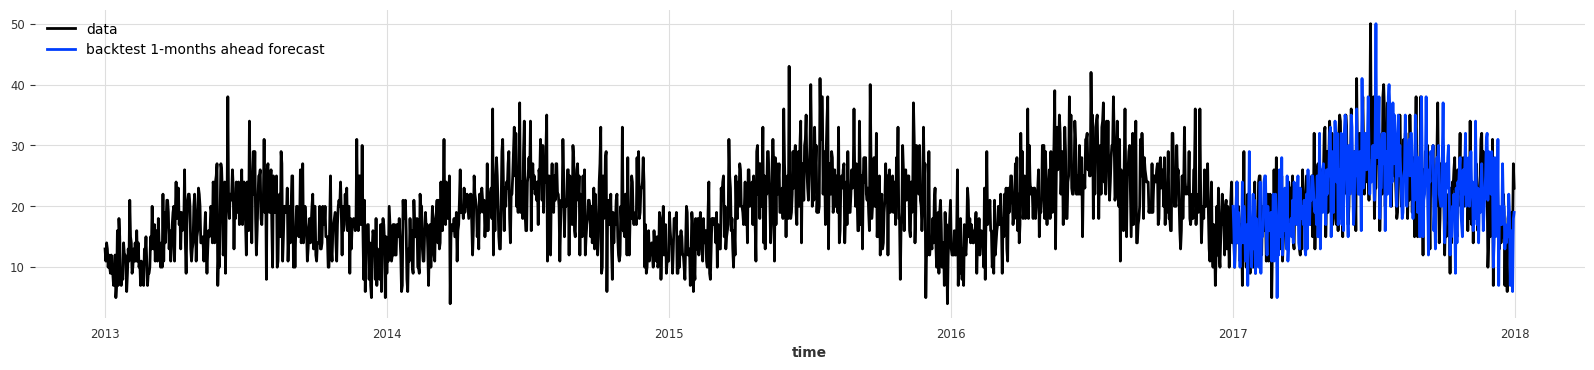

In [394]:
hfc_params = {
    "series": series.astype("float32"),
    "start": pd.Timestamp("2017-01-01"),  # can also be a float for the fraction of the series to start at
    "forecast_horizon": 1,
    "verbose": True,
}

historical_fcast = model.historical_forecasts(last_points_only=True, **hfc_params)

fig = plt.figure(figsize=(20, 4))
series.plot(label="data")
historical_fcast.plot(label="backtest 1-months ahead forecast")
print(f"MAPE = {mape(series, historical_fcast):.2f}%")

historical forecasts:   0%|          | 0/31 [00:00<?, ?it/s]

MAPE = 59.16%


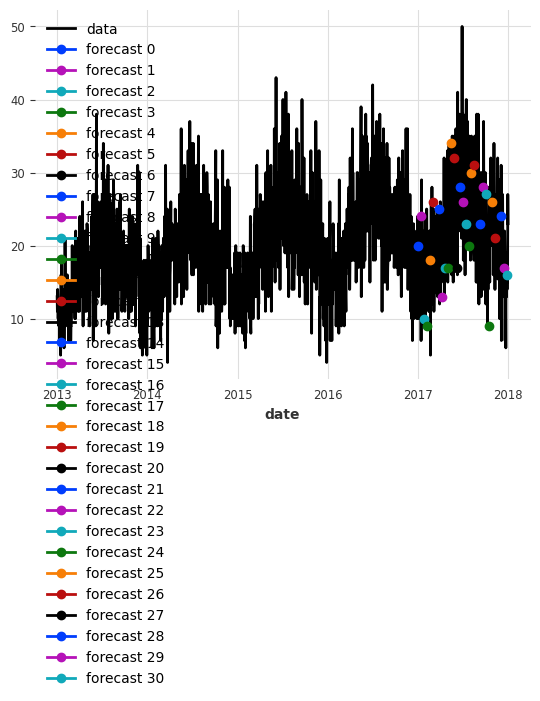

In [390]:
historical_fcast_all = model.historical_forecasts(last_points_only=False, stride=12, **hfc_params)

series.plot(label="data", linestyle='-')
for idx, hfc in enumerate(historical_fcast_all):
    hfc.plot(label=f"forecast {idx}", linestyle='-', marker='o')
    
from darts import concatenate
historical_fcast_all = concatenate(historical_fcast_all, axis=0, ignore_time_axis=True)
print(f"MAPE = {mape(series, historical_fcast_all):.2f}%")

Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

### Висновки

* Якщо розглядати кожну модель як модель для 1 айтема для 1 магазину, отримаємо 500 моделей сумарно. Для того, щоб трішки зменшити кількість моделей можемо "об'єднати" товари близькими за продажами для кожного магазину. Я розділив би на 10 категорій з 50 айтемів по кожному магазину за розміром **sales**. В даному випадку отримаємо 100 моделей, це зменшить навантаження на ресурси. 

* В даному випадку я б використовував би для початку наївну модель зі зміщенням та сезонністю, так як вона показала найкращі показники МАРЕ. Далі спробував би XGBoost так як в його також непогані показники. Для малих часових проміжків можемо використати Prophet, вона гарно передбачає тренд.

* Меншу кількість моделей я пояснюю зменшенням навантаження на сервер, хоча якщо тренування 1 моделі займатиме 1 секунду, то 500 секунд, наприклад по крону 1 запуск в день виглядає не таким поганим варіантом. Витрата 10 хв щодня на невеликому сервері не потребуватиме значних ресурсів. Тому 1 - зменшуємо до 100 моделей, якщо ресурси дозволяють - запускаємо по крону 1 раз на день. Основна модель - наївна модель із сезонністю та зміщенням, додаткова модель - XGBoost, а контрольна Prophet. Якщо усі 3 моделі показують таку ж тенденцію з відхиленням в 3 одиниці - приймаємо таке передбачення як основне. Якщо предикт 2-х моделей приймаємо це передбачення як основне, проте з нижчим рівнем впевненості. Якщо 3 моделі показали різні предикти - обираємо передбачення з найменшим відхиленням від попереднього дня. В такому випадку ми не даємо права вибору лише одній моделі, рішення приймають 2, або 3 із них. Якщо ж рішення приймає 1 модель - то з найменшими ризиками.